# Chapter 4: Training Models

1. When training linear regression on data with millions of features, you should use some form of gradient descent as neither the normal equation or SVD scale well on data with a lot of features.

2. Gradient descent based algorithms suffer when features have very different scales. If the features have very different scales the MSE cost function (that is being minimized) will be an elongated bowl shape with a flat(ish) valley. This will increase the time taken for gradient descent algorithms to converge. To mitigate this, use StandardScaler etc.

3. Gradient descent cannot get stuck when training a logistic regression model because the MSE cost function is convex, i.e. has no local minima.

4. No, stochastic models will never converge and its parameters will always jump around a little.

5. If your using batch gradient descent (all training data is used, as opposed to mini-batch which is stochastic), and validation error consistently goes up on the training curve, the model is likely overfitting the data and you should stop the training early. Alternatively the learning rate could be too high.

6. Because mini-batch gradient descent is stochastic, the cost function will not be monotonically decreasing on either train or validation data. Rather than stopping training the moment validation cost goes up, you should wait to see if the uptrend is persistent.

7. SGD will reach the vicinity of the optimal solution the fastest, but batch GD will actually converge given enough time. SGD & mini-batch GD only converge if the learning rate decreases over time.

8. When using polynomial regression, if there is a big gap between training error and validation error, then the model is likely overfitting the data. Three things you can do: lower the degree used, add regularization, or find more data.

9. If, when using ridge regression, the training error & validation error are almost equal and fairly high, then the model is underfitting. I.e. suffering more from bias in the bias-variance tradeoff. You should reduce the regularization hyperparameter.

10. a. Ridge regression prevents overfitting when compared to plane linear regression. b. Lasso regression is good at eliminating features which are not useful. c. Elastic net regression gives a balance of both ridge & lasso.

11. Two classifiers would be best, instead of softmax regression, because instances can be both indoor and at night, i.e. the classes are not exclusive.

## 12. Implementing batch gradient descent with early stopping for softmax regression using only numpy

In [1]:
import numpy as np
from matplotlib import pyplot as plt


np.random.seed(42)

In [2]:
def add_bias(X):
    return np.vstack(
        (
            np.ones(X.shape[0]),
            X.T,
        )
    ).T


def score(X, theta):
    return theta @ add_bias(X).T


def softmax(s):
    exp = np.exp(s)
    return exp / exp.sum(0, keepdims=True)


def target_prob(y):
    return np.array([y == _ for _ in np.unique(y)], float)


def p_hat(X, theta):
    return softmax(score(X, theta))


def cross_entropy_cost(X, y, theta):
    return -(target_prob(y) * np.log(p_hat(X, theta))).sum() / X.shape[0]


def grad(X, y, theta):
    return (p_hat(X, theta) - target_prob(y)) @ add_bias(X) / X.shape[0]


def predict(X, theta):
    return softmax(score(X, theta)).argmax(0)


def accuracy(y, y_hat):
    return (y == y_hat).sum() / y.size


def train_test_split(X, y, test_proportion=0.2):
    num_instances = X.shape[0]
    test_size = int(num_instances * test_proportion)
    indices = np.arange(num_instances)
    np.random.shuffle(indices)

    train_idx = indices[test_size:]
    test_idx = indices[:test_size]

    return X[train_idx], y[train_idx], X[test_idx], y[test_idx]


class BatchSoftmax:

    def __init__(self, learning_rate=0.1, n_epochs=5_000, early_stopping=False):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.early_stopping = early_stopping

    def fit(self, X, y):

        X_train, y_train, X_valid, y_valid = train_test_split(X, y)
        self.train_cost, self.valid_cost = [np.inf], [np.inf]
        self.train_accuracy, self.valid_accuracy = [0], [0]
        self.thetas = [np.random.randn(np.unique(y).size, X.shape[1] + 1)]

        for epoch in range(self.n_epochs):
            self.thetas.append(
                self.thetas[-1]
                - self.learning_rate * grad(X_train, y_train, self.thetas[-1])
            )

            self.train_cost.append(
                cross_entropy_cost(X_train, y_train, self.thetas[-1])
            )
            self.valid_cost.append(
                cross_entropy_cost(X_valid, y_valid, self.thetas[-1])
            )

            self.train_accuracy.append(
                accuracy(y_train, predict(X_train, self.thetas[-1]))
            )
            self.valid_accuracy.append(
                accuracy(y_valid, predict(X_valid, self.thetas[-1]))
            )

        if self.early_stopping:
            self.theta = self.thetas[np.array(self.valid_accuracy).argmax()]
        else:
            self.theta = self.thetas[-1]

    def predict(self, X):
        return predict(X, self.theta)

In [3]:
num_features = 2
num_instances = 100
num_classes = 4

X = np.random.rand(num_instances, num_features)

theta = np.array(
    [
        [+2, -9, -7],
        [+0, -8, -2],
        [-6, +5, -1],
        [-6, +2, +4],
    ]
)

y = softmax(score(X, theta) + 0.2 * np.random.randn(num_classes, num_instances)).argmax(
    0
)

In [4]:
model = BatchSoftmax()
model.fit(X, y)

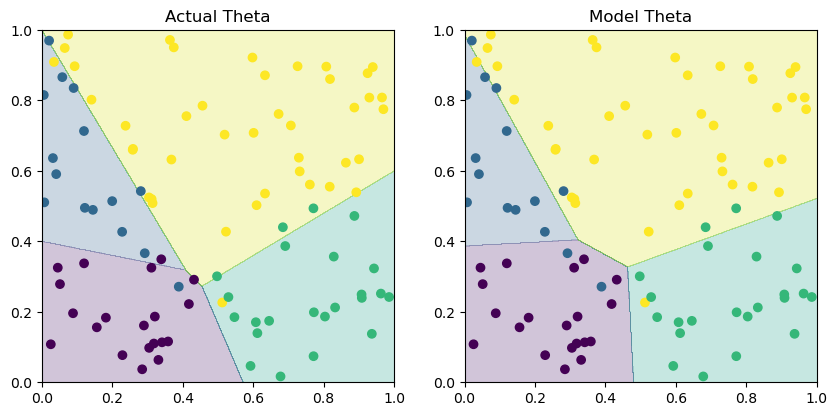

In [5]:
def plot_predictions(X, y, theta, ax=None):
    if ax is None:
        ax = plt.gca()
    x0, x1 = np.meshgrid(np.linspace(0, 1.0, 1000), np.linspace(0, 1.0, 1000))
    z = predict(np.hstack((x0.reshape(-1, 1), x1.reshape(-1, 1))), theta)

    ax.set_aspect("equal")
    ax.contourf(x0, x1, z.reshape(x0.shape), alpha=0.25)
    ax.scatter(X[:, 0], X[:, 1], c=y)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title("Actual Theta")
plot_predictions(X, y, theta, axs[0])
axs[1].set_title("Model Theta")
plot_predictions(X, y, model.theta, axs[1])

plt.show()

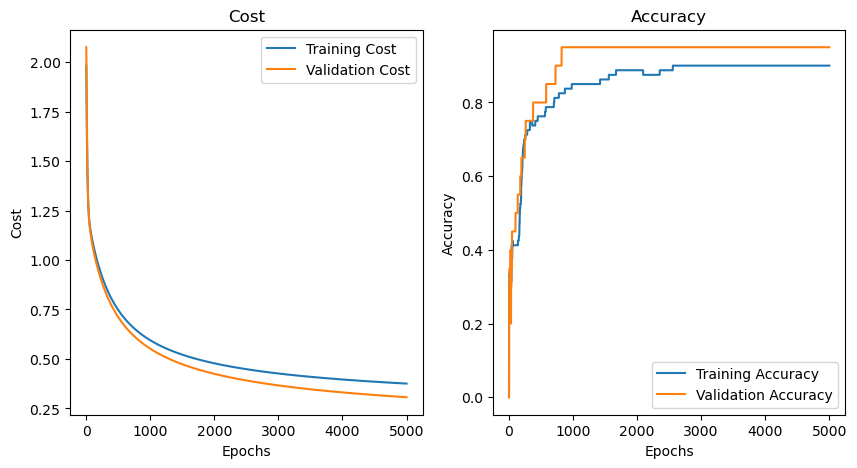

In [6]:
def plot_cost(model, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.train_cost, label="Training Cost")
    ax.plot(model.valid_cost, label="Validation Cost")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Cost")
    ax.legend()


def plot_accuracy(model, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.train_accuracy, label="Training Accuracy")
    ax.plot(model.valid_accuracy, label="Validation Accuracy")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()


def plot_model_performance(model):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].set_title("Cost")
    plot_cost(model, axs[0])
    axs[1].set_title("Accuracy")
    plot_accuracy(model, axs[1])

    plt.show()


plot_model_performance(model)

In [7]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler

iris = load_iris(as_frame=True)

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

X_train, y_train, X_test, y_test = train_test_split(X, y, 0.1)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

In [8]:
model = BatchSoftmax(early_stopping=True)
model.fit(X_train, y_train)

In [ ]:
plot_model_performance(model)

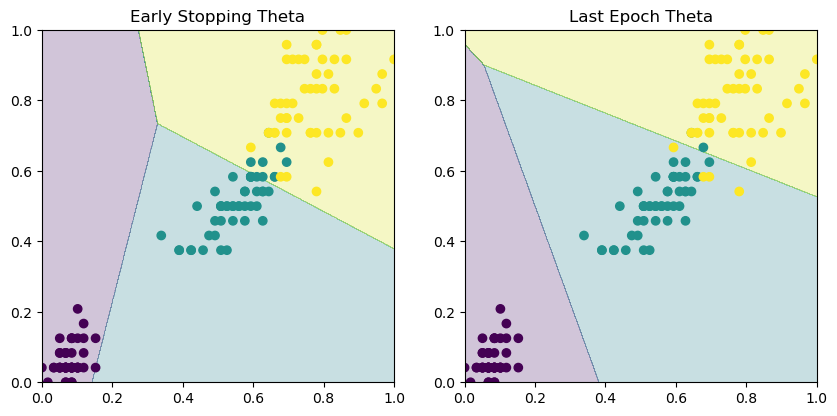

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title("Early Stopping Theta")
plot_predictions(X, y, model.theta, axs[0])
axs[1].set_title("Last Epoch Theta")
plot_predictions(X, y, model.thetas[-1], axs[1])

plt.show()